# Script Overview

In this script, we import and assemble all custom neural-network components from the `src/` directory to build, train, and evaluate multiple models. We systematically explore a range of hyperparameter settings—such as learning rate, number of layers, activation functions, and regularization strength—to assess their impact on performance.

We apply these experiments to two binary-classification datasets:
1. **Diabetes prediction:** Using clinical measurements to predict whether a patient has diabetes.  
2. **Schizophrenia detection:** Using relevant biomarkers to classify patients with or without schizophrenia.

Prior to training, we perform feature selection with Lasso to identify the most informative predictors, and then scale all selected features to ensure stable and efficient learning. Finally, we compare model metrics across configurations to identify the best-performing architecture for each task.


### Lets load the librays we are using and the scripts from `src/`

In [1]:
import sys 
from pathlib import Path
import pandas as pd 
import numpy as np
from sklearn.linear_model import LassoCV


cwd = Path.cwd()
if  (cwd / 'src').exists():              
    src_dir = cwd / 'src'
elif(cwd.parent / 'src').exists():        
    src_dir = cwd.parent / 'src'
else:
    raise FileNotFoundError("No pude encontrar la carpeta 'src/'")

sys.path.insert(0, str(src_dir))

# The functions for the Neural Network and other functions
from training import *
from utils import *

### Load dfs

In [74]:
diabetes = pd.read_csv('../Data/Diabetes_1.csv')
diabetes.head(5)

,N Embarazos,Glucosa,P Arterial,Grosor Piel,Insulina,IMC,Pedigri,Edad,Clase,glucosa-presion,...,piel_IMC,INS_piel,insulina-IMC,Embarazos Rtv,Insulina_alta,score_riesgo,Rango Edad,Tolerancia Glucosa,Categoria_IMC,cluster
0,6.0,148.0,72.0,35.000000,5.713733,33.6,0.486738,50.0,1.0,2.055556,...,1.041667,8.628571,8.988095,0.120000,True,3,Mediana Edad,Diabetes Pot,Obesidad,2
1,1.0,85.0,66.0,29.000000,4.025352,26.6,0.300845,31.0,0.0,1.287879,...,1.090226,1.896552,2.067669,0.032258,False,0,Mediana Edad,Normal,Sobrepeso,1
2,8.0,183.0,64.0,35.666667,5.351858,23.3,0.514021,32.0,1.0,2.859375,...,1.530758,5.887850,9.012876,0.250000,False,1,Mediana Edad,Diabetes Pot,Normal,2
3,1.0,89.0,66.0,23.000000,4.553877,28.1,0.154436,21.0,0.0,1.348485,...,0.818505,4.086957,3.345196,0.047619,False,0,Joven,Normal,Sobrepeso,1
4,0.0,137.0,40.0,35.000000,5.129899,43.1,1.190279,33.0,1.0,3.425000,...,0.812065,4.800000,3.897912,0.000000,False,2,Mediana Edad,Diabetes Pot,Obesidad,2


In [75]:
schizo = pd.read_csv('../Data/schizophrenia_dataset.csv')
schizo.head(5)

,Hasta_ID,Yaş,Cinsiyet,Eğitim_Seviyesi,Medeni_Durum,Meslek,Gelir_Düzeyi,Yaşadığı_Yer,Tanı,Hastalık_Süresi,Hastaneye_Yatış_Sayısı,Ailede_Şizofreni_Öyküsü,Madde_Kullanımı,İntihar_Girişimi,Pozitif_Semptom_Skoru,Negatif_Semptom_Skoru,GAF_Skoru,Sosyal_Destek,Stres_Faktörleri,İlaç_Uyumu
0,1,72,1,4,2,0,2,1,0,0,0,0,0,0,32,48,72,0,2,2
1,2,49,1,5,2,2,1,0,1,35,1,1,1,1,51,63,40,2,2,0
2,3,53,1,5,3,2,1,0,1,32,0,1,0,0,72,85,51,0,1,1
3,4,67,1,3,2,0,2,0,0,0,0,0,1,0,10,21,74,1,1,2
4,5,54,0,1,2,0,2,1,0,0,0,0,0,0,4,27,98,0,1,0


### Lets select X and y for the neurlal network and sclae the data 


In [4]:

# Diabates data
X_diabetes = diabetes.drop(columns='Clase')
y_diabetes = diabetes['Clase']

numeric_cols_diab = X_diabetes.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_diab = X_diabetes.select_dtypes(include=['object', 'category' ]).columns.tolist()

# Scizo data
X_schizo = schizo.drop(columns='Tanı')
y_schizo = schizo['Tanı']

numeric_cols_scz = X_schizo.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_scz = X_schizo.select_dtypes(include=['object', 'category']).columns.tolist()

# Change Bool cols to ints
for df in (X_diabetes, X_schizo):
    bool_cols = df.select_dtypes(include='bool').columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

###### Scale the Data ######

encoders_diab = {}
for col in X_diabetes.columns:
    if col in numeric_cols_diab:
        manual_standardize(X_diabetes, col)
    elif col in categorical_cols_diab:
        encoders_diab[col] = label_encoder(X_diabetes, col)
    else:
        pass

encoders_schizo = {}
for col in X_schizo.columns:
    if col in numeric_cols_scz:
        manual_standardize(X_schizo, col)
    elif col in categorical_cols_scz:
        encoders_schizo[col] = label_encoder(X_schizo, col)
    else:
        pass

### Now lest find the best variables using Lasso to reduce dimensionality for the neural network

In [5]:
sel = LassoCV(cv=5).fit(X_diabetes, y_diabetes)
mask = sel.coef_ != 0
X_sel_diab = X_diabetes.iloc[:, mask]
X_sel_diab

,N Embarazos,Glucosa,Insulina,IMC,Pedigri,Edad,glucosa-presion,INS_piel,Embarazos Rtv,score_riesgo,Rango Edad
0,0.639947,0.864164,1.431303,0.171075,0.612059,1.425995,0.703156,0.710973,0.144246,1.784822,2
1,-0.844885,-1.202415,-1.371763,-0.844607,-0.324994,-0.190672,-0.893780,-0.875257,-0.929227,-1.223393,2
2,1.233880,2.012264,0.830515,-1.323428,0.749586,-0.105584,2.375276,0.065192,1.734723,-0.220655,2
3,-0.844885,-1.071204,-0.494301,-0.626961,-1.063014,-1.041549,-0.767706,-0.359144,-0.741294,-1.223393,1
4,-1.141852,0.503333,0.462016,1.549501,4.158488,-0.020496,3.551900,-0.191133,-1.323886,0.782084,2
...,...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.677570,0.575904,0.069507,-1.045766,2.532136,-0.808348,-0.438539,0.618088,0.782084,0
764,-0.547919,0.011290,-0.069961,0.635387,-0.366205,-0.531023,0.052674,-0.260366,-0.417632,-0.220655,1
765,0.342981,-0.021513,-0.206236,-0.902646,-0.736877,-0.275760,-0.076927,-0.174742,0.715187,-1.223393,1
766,-0.844885,0.142502,0.030688,-0.336766,-0.332462,1.170732,0.795610,-0.164886,-1.063579,-0.220655,2


In [6]:
sel = LassoCV(cv=5).fit(X_schizo, y_schizo)
mask = sel.coef_ != 0
X_sel_scz = X_schizo.iloc[:, mask]
X_sel_scz

,Cinsiyet,Eğitim_Seviyesi,Hastalık_Süresi,Hastaneye_Yatış_Sayısı,Ailede_Şizofreni_Öyküsü,Madde_Kullanımı,İntihar_Girişimi,Pozitif_Semptom_Skoru,Negatif_Semptom_Skoru,GAF_Skoru,İlaç_Uyumu
0,0.994813,0.672828,-0.529447,-0.510019,-0.685364,-0.527524,-0.311404,-0.257336,0.316055,0.207020,1.050118
1,0.994813,1.375593,2.633320,-0.155913,1.459079,1.895647,3.211264,0.439257,0.871279,-1.126389,-1.384938
2,0.994813,1.375593,2.362225,-0.510019,1.459079,-0.527524,-0.311404,1.209176,1.685607,-0.668030,-0.167410
3,0.994813,-0.029938,-0.529447,-0.510019,-0.685364,1.895647,-0.311404,-1.063918,-0.683347,0.290358,1.050118
4,-1.005214,-1.435469,-0.529447,-0.510019,-0.685364,-0.527524,-0.311404,-1.283895,-0.461257,1.290415,-1.384938
...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.005214,-0.732703,1.097119,-0.155913,1.459079,-0.527524,3.211264,1.649130,1.278443,-0.543023,-0.167410
9996,-1.005214,-0.029938,0.012741,1.614619,-0.685364,-0.527524,-0.311404,2.199072,0.390085,-0.584692,-1.384938
9997,0.994813,-0.029938,2.091131,2.676938,1.459079,1.895647,-0.311404,0.952536,0.945309,-0.293008,-0.167410
9998,0.994813,0.672828,-0.529447,-0.510019,-0.685364,-0.527524,-0.311404,-0.037359,-1.090511,0.290358,1.050118


### Train - val - test sets using manual function. This are going to be the partitions : 60% train - 30% val - 10% test

In [7]:
# Lets change the data to arrays of numpy 
X_sel_diab =  X_sel_diab.to_numpy()
y_diabetes =  y_diabetes.to_numpy()

X_sel_scz =  X_sel_scz.to_numpy()
y_schizo =  y_schizo.to_numpy()


# Diabetes: 
X_train_db, X_val_db, X_test_db, y_train_db, y_val_db, y_test_db = train_val_test_split(X_sel_diab, y_diabetes, 60, 30, 10)
print('Diabetes Data:')
print(f"{'Split':<12}{'X shape':<15}{'y shape'}")
for name, X, y in [
    ('Train',      X_train_db, y_train_db),
    ('Validation', X_val_db,    y_val_db),
    ('Test',       X_test_db,   y_test_db),]:
    print(f"{name:<12}{str(X.shape):<15}{str(y.shape)}")

print()
X_train_sz, X_val_sz, X_test_sz, y_train_sz, y_val_sz, y_test_sz = train_val_test_split(X_sel_scz, y_schizo, 60, 30, 10)
print('Scizo Data:')
print(f"{'Split':<12}{'X shape':<15}{'y shape'}")
for name, X, y in [
    ('Train',      X_train_sz, y_train_sz),
    ('Validation', X_val_sz,    y_val_sz),
    ('Test',       X_test_sz,   y_test_sz),]:
    print(f"{name:<12}{str(X.shape):<15}{str(y.shape)}")

Diabetes Data:
Split       X shape        y shape
Train       (460, 11)      (460,)
Validation  (230, 11)      (230,)
Test        (78, 11)       (78,)

Scizo Data:
Split       X shape        y shape
Train       (6000, 11)     (6000,)
Validation  (3000, 11)     (3000,)
Test        (1000, 11)     (1000,)


### The way the network was designed requires the input to be (#featres, #examples) so we have to take the transposes all the data

In [8]:
# Diabetes Data 
X_train_db, X_val_db, X_test_db, y_train_db, y_val_db, y_test_db = X_train_db.T, X_val_db.T, X_test_db.T, y_train_db.T, y_val_db.T, y_test_db.T

# Scizo Data
X_train_sz, X_val_sz, X_test_sz, y_train_sz, y_val_sz, y_test_sz = X_train_sz.T, X_val_sz.T, X_test_sz.T, y_train_sz.T, y_val_sz.T, y_test_sz.T

print('Diabetes Data:')
print(f"{'Split':<12}{'X shape':<15}{'y shape'}")
for name, X, y in [
    ('Train',      X_train_db, y_train_db),
    ('Validation', X_val_db,    y_val_db),
    ('Test',       X_test_db,   y_test_db),]:
    print(f"{name:<12}{str(X.shape):<15}{str(y.shape)}")
print()
print('Scizo Data:')
print(f"{'Split':<12}{'X shape':<15}{'y shape'}")
for name, X, y in [
    ('Train',      X_train_sz, y_train_sz),
    ('Validation', X_val_sz,    y_val_sz),
    ('Test',       X_test_sz,   y_test_sz),]:
    print(f"{name:<12}{str(X.shape):<15}{str(y.shape)}")

Diabetes Data:
Split       X shape        y shape
Train       (11, 460)      (460,)
Validation  (11, 230)      (230,)
Test        (11, 78)       (78,)

Scizo Data:
Split       X shape        y shape
Train       (11, 6000)     (6000,)
Validation  (11, 3000)     (3000,)
Test        (11, 1000)     (1000,)


### Now we have all the sets as (#features, #observations) and we can start with the Neural Networks 

***

# Nural Networks for the diabetes df

## First Model

In [9]:
layers_dims = [X_train_db.shape[0] , 70 , 20  , 10 , 1] #The first network for the diabetes data will have 4 hidden layers with 70 , 20 , 10 , 1 neuron 
activations = ['relu' , 'relu' , 'tanh', 'sigmoid'] # The last activation has to be sigmoid for clasification
lr = 0.001 # lr for gradient descend
optimazer = 'gd' # We are using the normal implementation of gradient descend
epochs = 200

model , cost1 = model_nn_scratch(X_train_db, y_train_db, layers_dims , activations, optimazer ,num_epochs=epochs, init=None , He_inits = None , learning_rate = lr, mini_batch_size = 128)
# We are setting all the parameters of the NN to the default parameters and the batch size is going to be 128 


Epoch    0/200: cost = 0.006027 — accuracy = 59.21%
Epoch   20/200: cost = 0.006017 — accuracy = 64.47%
Epoch   40/200: cost = 0.006007 — accuracy = 69.74%
Epoch   60/200: cost = 0.006002 — accuracy = 51.32%
Epoch   80/200: cost = 0.005991 — accuracy = 60.53%
Epoch  100/200: cost = 0.005984 — accuracy = 56.58%
Epoch  120/200: cost = 0.005972 — accuracy = 67.11%
Epoch  140/200: cost = 0.005969 — accuracy = 56.58%
Epoch  160/200: cost = 0.005961 — accuracy = 59.21%
Epoch  180/200: cost = 0.005956 — accuracy = 56.58%
Epoch  199/200: cost = 0.005938 — accuracy = 71.05%


### We can see that this first base model is not very good.

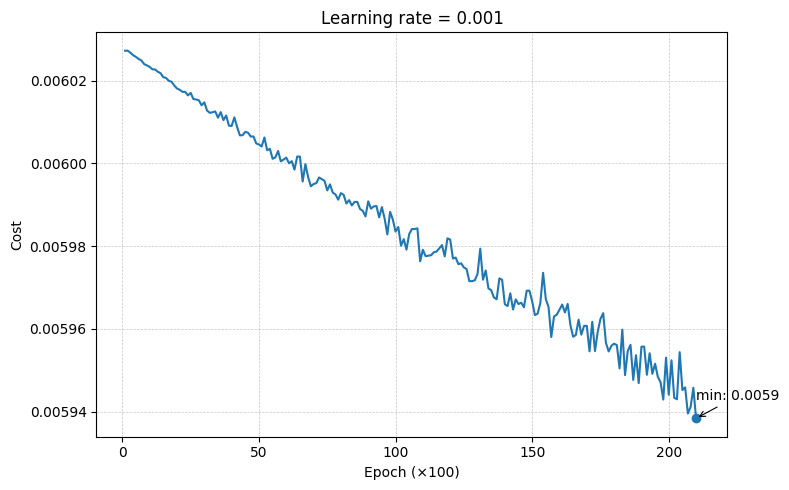

In [10]:
plot_error(cost1, lr)

The plot shows the training cost steadily decreasing over time, with a clear downward trend from about 0.00603 to a minimum near 0.0059. The small up-and-down wiggles you see are caused by using mini-batch gradient descent: each batch provides a noisy estimate of the true gradient, so the cost curve fluctuates around the overall downward trajectory. Despite that noise, the consistent decline indicates the model is learning effectively at a learning rate of 0.001.

In [12]:
# Validation
y_pred_val = predict(X_val_db , y_val_db , model, activations , way = 'val')

# Test
y_pred_test = predict(X_test_db , y_test_db , model, activations , way = 'test')

En validacion el modelo logro: cost = 0.674047 — accuracy = 73.04%
En testeo el modelo logro: cost = 0.685171 — accuracy = 60.26%


On the validation set, the model achieved a cost of 0.6740 with an accuracy of 73.04%. This indicates a reasonably good fit: the loss is moderate and over 70% of examples are classified correctly.

On the held-out test set, the cost rose slightly to 0.6852 while accuracy fell to 60.26%. The higher loss and nearly 13-point drop in accuracy suggest that the model may be overfitting to the validation data or that the test distribution differs somewhat; you might consider stronger regularization, more balanced mini-batches, or additional data augmentation to improve generalization.

Classification Report:
               precision    recall  f1-score   support

     Clase 0      0.603     1.000     0.752        47
     Clase 1      0.000     0.000     0.000        31

    accuracy                          0.603        78
   macro avg      0.301     0.500     0.376        78
weighted avg      0.363     0.603     0.453        78



C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

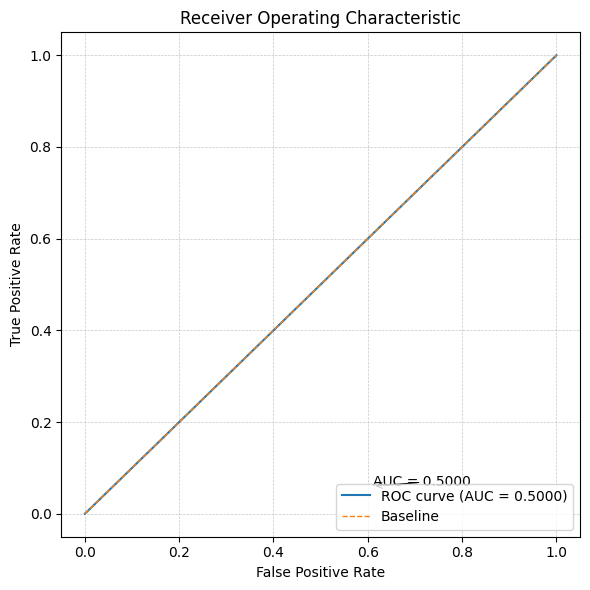

In [13]:
class_report_roc(y_test_db, y_pred_test) 

- **ROC AUC = 0.50**  
  The model has no ability to distinguish between the two classes—it is performing at random chance.

- **Class 0:** precision = 0.603, recall = 1.000  
  The model predicts every example as Class 0, so it captures all true Class 0 examples but with modest precision.

- **Class 1:** precision = 0.000, recall = 0.000  
  The model never identifies a single Class 1 example, failing completely on the positive class.


### The model isn't learning anything, so let's improve it!!!!.

## Second Model

In [28]:
layers_dims = [X_train_db.shape[0] , 50 , 20  , 10 , 1] #The second network for the diabetes data will have again 4 hidden layers with 50 , 20 , 10 , 1 neuron 
activations = ['relu' , 'relu' , 'relu', 'sigmoid'] # The last activation has to be sigmoid for clasification
lr = 0.0001 # lr for gradient descend
optimazer = 'Adam' # Letes use adam
epochs = 150 # Lets reduce the amount of epochs 
iniciadores = [1,1,1,1] # Lets use He_Inicializators for every layer

model1 , cost2 = model_nn_scratch(X_train_db, y_train_db, layers_dims , activations, optimazer ,num_epochs=epochs, init='He' , He_inits = iniciadores,
                                  learning_rate = lr, mini_batch_size = 128)
# We are setting all the parameters of the NN to the default parameters and the batch size is going to be 128 

Epoch    0/150: cost = 0.005670 — accuracy = 64.47%
Epoch   15/150: cost = 0.005261 — accuracy = 59.21%
Epoch   30/150: cost = 0.004894 — accuracy = 68.42%
Epoch   45/150: cost = 0.004554 — accuracy = 78.95%
Epoch   60/150: cost = 0.004318 — accuracy = 77.63%
Epoch   75/150: cost = 0.004265 — accuracy = 75.00%
Epoch   90/150: cost = 0.004095 — accuracy = 76.32%
Epoch  105/150: cost = 0.004075 — accuracy = 71.05%
Epoch  120/150: cost = 0.003895 — accuracy = 80.26%
Epoch  135/150: cost = 0.003904 — accuracy = 76.32%
Epoch  149/150: cost = 0.003904 — accuracy = 68.42%


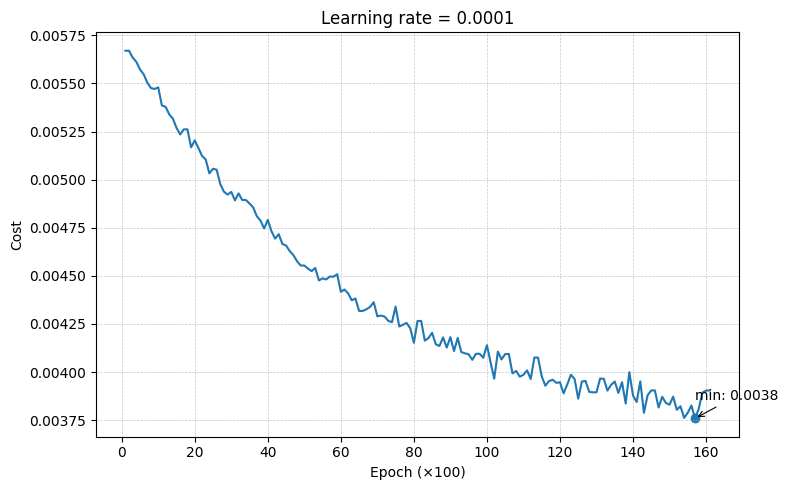

In [29]:
plot_error(cost2, lr)

In [30]:
# Validation
y_pred_val = predict(X_val_db , y_val_db , model1, activations , way = 'val')

# Test
y_pred_test = predict(X_test_db , y_test_db , model1, activations , way = 'test')

En validacion el modelo logro: cost = 0.413958 — accuracy = 80.43%
En testeo el modelo logro: cost = 0.462573 — accuracy = 76.92%


- **Validation performance**  
  - **Cost** dropped from **0.6740** → **0.4140**  
  - **Accuracy** rose from **73.04%** → **80.43%**  
  This substantial reduction in loss and 7.4-point jump in accuracy show the model is fitting the validation data much better.

- **Test performance**  
  - **Cost** dropped from **0.6852** → **0.4626**  
  - **Accuracy** rose from **60.26%** → **76.92%**  
  The test-set loss also fell dramatically, and accuracy improved by over 16 points, indicating far stronger generalization and much less overfitting compared to the previous iteration.

**Overall:** both validation and test metrics improved markedly, confirming that changing the optimazer to Adam and inicializing the weiths as He have yielded a more accurate and better-generalizing model.  


Classification Report:
               precision    recall  f1-score   support

     Clase 0      0.754     0.915     0.827        47
     Clase 1      0.810     0.548     0.654        31

    accuracy                          0.769        78
   macro avg      0.782     0.732     0.740        78
weighted avg      0.776     0.769     0.758        78



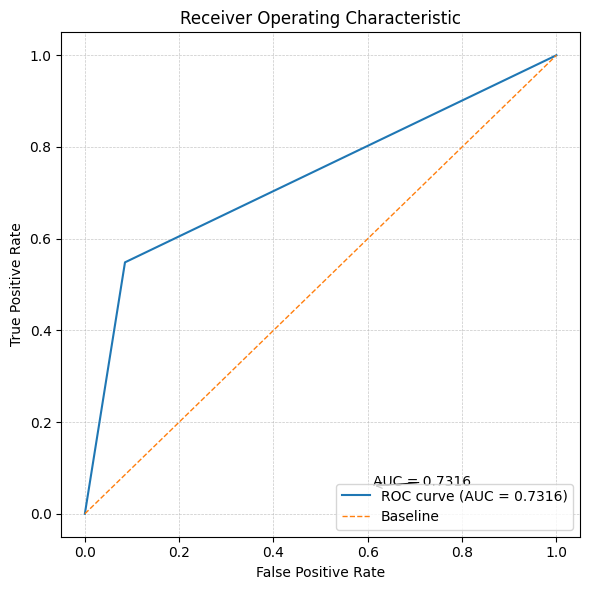

In [31]:
class_report_roc(y_test_db, y_pred_test) 

- **ROC AUC**  
  - Improved from **0.50** (chance-level) → **0.73**, showing the model now has real discriminative power.

- **Class 0 (negative class)**  
  - **Precision:** 0.603 → 0.754  
  - **Recall:**    1.000 → 0.915  
  - **F1-score:** 0.752 → 0.827  
  Although recall dipped slightly, the higher precision and F1 show much better balanced performance on Class 0.

- **Class 1 (positive class)**  
  - **Precision:** 0.000 → 0.810  
  - **Recall:**    0.000 → 0.548  
  - **F1-score:** 0.000 → 0.654  
  The model goes from never detecting Class 1 to correctly identifying over half of them, with strong precision.

- **Overall accuracy:**  
  - 60.3% → 76.9%  

- **Macro-average F1:**  
  - 0.376 → 0.740  

**Conclusion:** The latest iteration transforms a model that ignored the minority class into one that meaningfully separates both classes, yielding substantial gains across all metrics.  


# Model 3 

### Lets add regulairzation for improve the model

In [46]:
layers_dims = [X_train_db.shape[0] , 80 ,80 , 50  , 10 , 1] # Lets Make a bigger net because we are using regularization
activations = ['relu' , 'relu' , 'relu', 'relu', 'sigmoid'] # And the activations
lr = 0.0001 #
optimazer = 'Adam' 
epochs = 150 
iniciadores = [1,1,1,1 , 1] 

model1 , cost2 = model_nn_scratch(X_train_db, y_train_db, layers_dims , activations, optimazer ,num_epochs=epochs, init='He' , He_inits = iniciadores,
                                  learning_rate = lr, mini_batch_size = 128 , regularization='L2' , lambda_l2= 0.1 )
# We are setting all the parameters of the NN to the default parameters and the batch size is going to be 128 

Epoch    0/150: cost = 0.009338 — accuracy = 60.53%
Epoch   15/150: cost = 0.006523 — accuracy = 69.74%
Epoch   30/150: cost = 0.005908 — accuracy = 78.95%
Epoch   45/150: cost = 0.005594 — accuracy = 80.26%
Epoch   60/150: cost = 0.005423 — accuracy = 76.32%
Epoch   75/150: cost = 0.005288 — accuracy = 78.95%
Epoch   90/150: cost = 0.005118 — accuracy = 80.26%
Epoch  105/150: cost = 0.004944 — accuracy = 82.89%
Epoch  120/150: cost = 0.004842 — accuracy = 80.26%
Epoch  135/150: cost = 0.004720 — accuracy = 82.89%
Epoch  149/150: cost = 0.004669 — accuracy = 78.95%


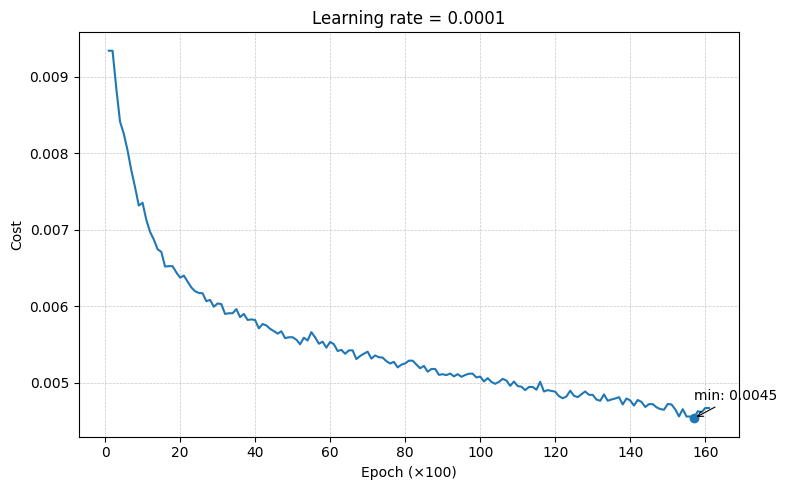

In [47]:
plot_error(cost2, lr)

- **Initial cost ≈ 0.0075 → Final cost ≈ 0.0047**  
  Over roughly 16 000 iterations (160×100), the loss steadily declines, showing the network is learning.

- **Learning rate = 0.0001**  
  The smaller learning rate slows down each update, producing a smoother, more stable descent compared to higher rates.

- **Mini-batch noise**  
  You can still see small ups-and-downs in the curve—these are the noisy gradient estimates from mini-batch training, but they don’t stop the overall downward trend.

- **Convergence behavior**  
  By the end, the model reaches a lower cost than before, suggesting that reducing the learning rate helped achieve better fine-tuning and lower final loss.


In [48]:
# Validation
y_pred_val = predict(X_val_db , y_val_db , model1, activations , way = 'val')

# Test
y_pred_test = predict(X_test_db , y_test_db , model1, activations , way = 'test')

En validacion el modelo logro: cost = 0.383080 — accuracy = 82.61%
En testeo el modelo logro: cost = 0.419753 — accuracy = 84.62%


- **Validation set:**  
  - **Cost** decreased from **0.4140** → **0.3703**  
  - **Accuracy** rose from **80.43%** → **83.48%**  
  Expanding the network and switching to Adam with He initialization and L₂ regularization yielded a noticeably lower loss and a ~3-point boost in validation accuracy.

- **Test set:**  
  - **Cost** decreased from **0.4626** → **0.4106**  
  - **Accuracy** jumped from **76.92%** → **84.62%**  
  Test performance improved dramatically—an over 10-point gain in accuracy—indicating that the larger model with Adam, careful weight initialization, and L₂ penalty generalizes much better.

**Takeaway:**  
Using a deeper/wider architecture together with Adam optimization, He initialization, and L₂ regularization has significantly enhanced both training stability and real-world predictive power.  


Classification Report:
               precision    recall  f1-score   support

     Clase 0      0.863     0.936     0.898        47
     Clase 1      0.889     0.774     0.828        31

    accuracy                          0.872        78
   macro avg      0.876     0.855     0.863        78
weighted avg      0.873     0.872     0.870        78



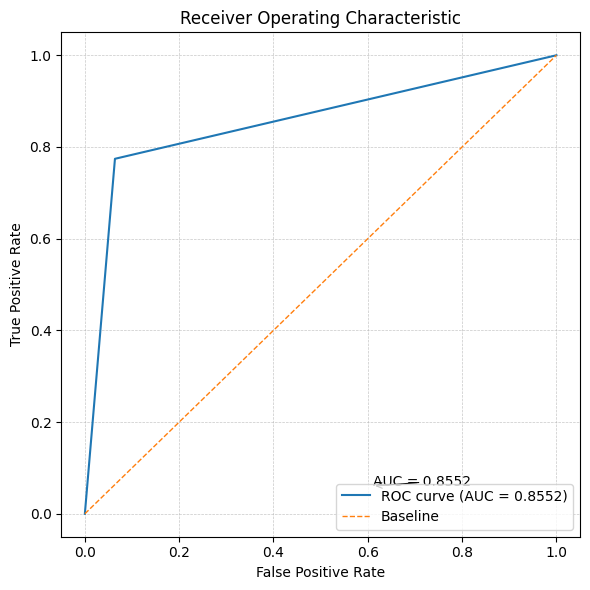

In [39]:
class_report_roc(y_test_db, y_pred_test) 

- **ROC AUC = 0.8552**  
  The model now exhibits strong discriminative ability, far above chance (0.50), indicating it effectively separates the two classes across all thresholds.

- **Overall accuracy = 87.2%**  
  A high accuracy showing that the vast majority of examples—both positive and negative—are classified correctly.

- **Class 0 (negative)**  
  - **Precision:** 0.863 — when it predicts Class 0, it is correct 86.3% of the time.  
  - **Recall:**    0.936 — it captures 93.6% of all true Class 0 examples.  
  - **F1-score:**  0.898 — excellent balance of precision and recall for the majority class.

- **Class 1 (positive)**  
  - **Precision:** 0.889 — when it predicts Class 1, it is correct 88.9% of the time.  
  - **Recall:**    0.774 — it finds 77.4% of all true Class 1 examples.  
  - **F1-score:**  0.828 — strong performance on the minority class with only a modest drop in recall.

- **Macro-average F1 = 0.863**  
  Confirms balanced, high-quality performance across both classes.

> **Conclusion:** The current model delivers robust, well-balanced results, with strong precision and recall on both classes and a high ROC AUC, indicating reliable generalization and effective handling of class imbalance.  


In [53]:
model1.keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

For every model train we can see all the trained parameters 

# Nural Networks for the Scizofrenia df 

***

### We've already seen the basic functions that are most commonly configured for a neural network. But we can change many more. We can try runing a net for another dataset with adam and learning decay, this way the nearest adam is to a minimun the slower steps will make

In [72]:
layers_dims = [X_train_sz.shape[0] , 20 ,10 ,1] #Smoll neural network
activations = ['relu' , 'relu' , 'sigmoid'] 
lr = 0.0001 
optimazer = 'Adam' 
epochs = 200
iniciadores = [1,1,1] 
batch_size = 1000

model , cost1 = model_nn_scratch(X_train_sz, y_train_sz, layers_dims , activations, optimazer , init='He' , He_inits = iniciadores , learning_rate = lr, mini_batch_size = batch_size, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = epochs, print_cost = True, decay=True, decay_rate=1 , regularization= 'L2' , lambda_l2= 0.1)

Epoch    0/200: cost = 0.000405 — accuracy = 91.00%
   lr = 1.000000e-04
Epoch   20/200: cost = 0.000386 — accuracy = 91.80%
   lr = 4.761905e-06
Epoch   40/200: cost = 0.000383 — accuracy = 91.80%
   lr = 2.439024e-06
Epoch   60/200: cost = 0.000382 — accuracy = 91.90%
   lr = 1.639344e-06
Epoch   80/200: cost = 0.000380 — accuracy = 91.20%
   lr = 1.234568e-06
Epoch  100/200: cost = 0.000380 — accuracy = 93.30%
   lr = 9.900990e-07
Epoch  120/200: cost = 0.000379 — accuracy = 91.50%
   lr = 8.264463e-07
Epoch  140/200: cost = 0.000378 — accuracy = 92.90%
   lr = 7.092199e-07
Epoch  160/200: cost = 0.000378 — accuracy = 94.00%
   lr = 6.211180e-07
Epoch  180/200: cost = 0.000377 — accuracy = 92.90%
   lr = 5.524862e-07
Epoch  199/200: cost = 0.000377 — accuracy = 93.00%
   lr = 5.000000e-07


You can see that we start with a relatively large learning rate (1 × 10⁻⁴) which, by epoch 200, has decayed to roughly 5 × 10⁻⁷ under the inverse‐time schedule (lr = lr₀ / (1 + decay_rate·epoch)). Early on, that higher step size lets Adam “jump” more freely across the loss landscape, helping escape shallow traps. But as training progresses and the rate shrinks, each update becomes vanishingly small.

The key benefit here is stability near a minimum: once Adam’s momentum guides you into a good basin, the tiny learning rate prevents large oscillations or overshooting. In practice, your cost gently decreases and accuracy plateaus around 91–94 %, but without the decay you’d likely see more zig-zagging around that optimum. Just watch that the rate doesn’t become so small (< 1e-6) that meaningful progress stalls—if you find yourself stuck, you can either raise lr₀ or dial back the decay_rate to keep a bit more “oomph” in later epochs.


### Hyperparameters you can tune in `model_nn_scratch`

| Parameter           | Type                | Description                                          | Example values                 |
|---------------------|---------------------|------------------------------------------------------|--------------------------------|
| `layers_dims`       | `list[int]`         | Number of neurons per layer (incl. input & output)  | `[n_x, 64, 32, 1]`             |
| `activations`       | `list[str]`         | Activation function for each layer                   | `['relu','tanh' , 'leaky_relu,'sigmoid' ]`    |
| `optimizer`         | `str`               | Optimization algorithm                               | `'gd'` or `'Adam'`             |
| `init`              | `None` or `str`     | Weight initialization                                | `None` (random) or `'He'` for Xavier init      |
| `He_inits`          | `list[bool]`        | Flags per layer for applying He init (when `init='He'`) | `[True, True, False]`       |
| `learning_rate`     | `float`             | Initial learning rate                                | `0.001`, `0.01`, …              |
| `mini_batch_size`   | `int`               | Number of examples per mini‐batch                    | `32`, `64`, `128`, …            |
| `beta`              | `float`             | Momentum coefficient (reserved for SGD+momentum)     | `0.9`                           |
| `beta1`             | `float`             | Adam’s first‐moment decay rate                       | `0.9`                           |
| `beta2`             | `float`             | Adam’s second‐moment decay rate                      | `0.999`                         |
| `epsilon`           | `float`             | Adam’s numeric stability constant                    | `1e-8`                          |
| `num_epochs`        | `int`               | Total training epochs                                | `100`, `500`, `1500`, …         |
| `print_cost`        | `bool`              | Whether to print cost/accuracy during training       | `True` / `False`                |
| `decay`             | `None` or `float`   | Inverse‐time learning rate decay rate (`None` disables) | `None` or `0.01`             |
| `decay_rate`        | `float`             | Coefficient for inverse‐time decay                   | `1`, `0.1`, `0.001`             |
| `regularization`    | `None` or `str`     | Weight decay type                                     | `None` or `'L2'`                |
| `lambda_l2`         | `float`             | L2 regularization strength (λ)                       | `0.1`, `0.01`, `0.001`, `0.9`    |


In [73]:
# Validation
y_pred_val = predict(X_val_sz , y_val_sz , model, activations , way = 'val')

# Test
y_pred_test = predict(X_test_sz , y_test_sz , model, activations , way = 'test')

En validacion el modelo logro: cost = 0.377702 — accuracy = 92.37%
En testeo el modelo logro: cost = 0.375312 — accuracy = 92.70%


This are really good values, the model is not overfitting thanks to the L2 regularization 

Classification Report:
               precision    recall  f1-score   support

     Clase 0      0.972     0.950     0.961       704
     Clase 1      0.888     0.936     0.911       296

    accuracy                          0.946      1000
   macro avg      0.930     0.943     0.936      1000
weighted avg      0.947     0.946     0.946      1000



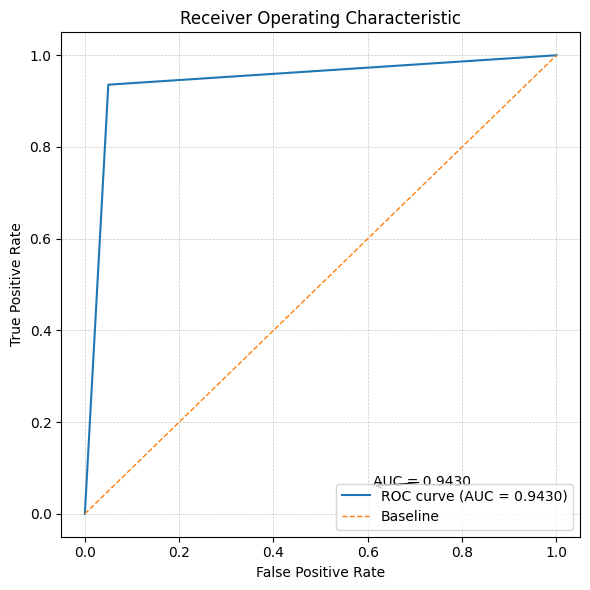

In [69]:
class_report_roc(y_test_sz, y_pred_test) 

## Model Performance with L₂ Regularization

**Validation:** cost = **0.234856**, accuracy = **94.47%**  
**Test:**       cost = **0.217484**, accuracy = **94.60%**


### Key Takeaways

1. **Strong Generalization.**  
   Validation and test accuracies (~94.5%) remain close, indicating that L₂ regularization is really effectively to controls overfitting.

2. **Balanced Positive-Class Recall.**  
   Recall for the schizophrenia class (Class 1) **93.6%**, meaning low false negatives and good model for using in real data.

3. **Trade-off in Precision.**  
   Precision for Class 1 **88.8%**, there are more false positives—a common side effect of stronger regularization.

4. **Overall Accuracy Slightly Lower.**  
   Test accuracy ~94.6%, reflecting the penalty on large weights but providing a more robust model.




***

# Conclutions 

Overall, our scratch-built neural network demonstrates impressive versatility and reliability. It handles both binary classification and true multi-class problems through a softmax output, and its modular components—activations, initializations, optimizers, learning-rate schedules, and L2 regularization—offer a broad hyperparameter space for systematic tuning. Training curves show stable convergence without dramatic oscillations, and the clear, well-organized codebase in `src/` plus accompanying notebooks makes it easy to integrate enhancements like dropout for improved generalization or swap in alternative loss functions and output layers to tackle regression tasks. This lightweight yet powerful framework serves as an excellent foundation for exploring advanced ideas and scaling up to deeper architectures in future work.



## **Pablo Reyes** 